In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import func, create_engine, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [1]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [77]:
#Finding max date
find_dates = session.query(func.max(func.strftime("%Y-%m-%d",Measurement.date))).all()
find_dates[0][0]

'2017-08-23'

In [42]:
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

In [43]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_table = pd.DataFrame(precipitation_data, columns = ['date', 'precipitation'])
precipitation_table.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [44]:
#Set the index to the date column
precipitation_table = precipitation_table.set_index('date')
precipitation_table.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [45]:
# Sort the dataframe by date
precipitation_table = precipitation_table.sort_index(ascending=True)
precipitation_table.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


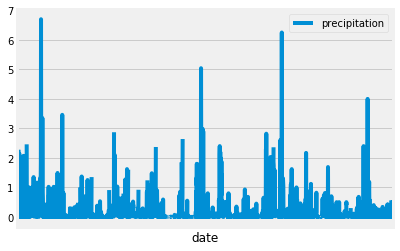

In [72]:
precipitation_table.plot()
plt.xticks([])
plt.savefig("Resources/precipitation.png")

![precipitation](Images/precipitation.png)

In [47]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_table.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [21]:
# Design a query to show how many stations are available in this dataset?
total_stations_available = session.query(Station).count()
total_stations_available



9

In [31]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [38]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
highest_station = active_stations[0][0]

highest_temp = (session.query(Measurement.tobs).filter(Measurement.station == highest_station).order_by(Measurement.tobs.desc()).first())
highest_temp = highest_temp[0]

lowest_temp = (session.query(Measurement.tobs).filter(Measurement.station == highest_station).order_by(Measurement.tobs.asc()).first())
lowest_temp = lowest_temp[0]

average_temp = (session.query(func.avg(Measurement.tobs)).filter(Measurement.station == highest_station))
average_temp = '{0:.3}'.format(average_temp[0][0])

print(f"The highest temperature is {highest_temp}")
print(f"The lowest temperature is {lowest_temp}")
print(f"The average temperature is {average_temp}")

The highest temperature is 85.0
The lowest temperature is 54.0
The average temperature is 71.7


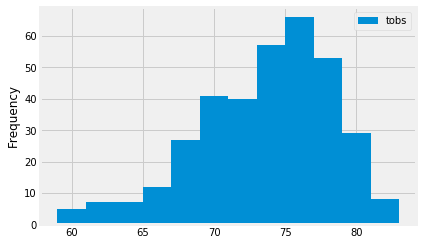

In [73]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == highest_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

station_data = pd.DataFrame(station_data)
station_data = station_data.set_index('date')
station_data = station_data.sort_index(ascending=True)

station_data.plot(kind='hist', bins=12)

plt.savefig("Resources/histogram.png")

![precipitation](Images/station-histogram.png)

In [57]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [61]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
billy_trip = '2019-05-18 to \n 2019-05-25' 
start = '2017-05-18'
end = '2017-05-25'

trip_temperatures = calc_temps(start, end)
trip_temperatures


[(68.0, 74.44444444444444, 87.0)]

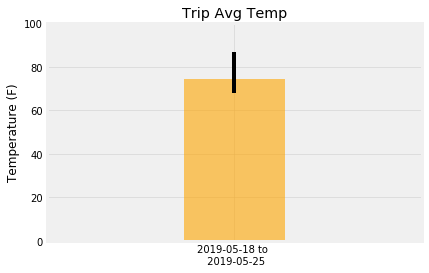

In [74]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

mintemp = trip_temperatures[0][0]
avgtemp = trip_temperatures[0][1]
maxtemp = trip_temperatures[0][2]

min_error = avgtemp - mintemp
max_error = maxtemp - avgtemp

error_bars = np.array([[min_error], [max_error]])

plt.bar(billy_trip, avgtemp, yerr=error_bars, color='orange', alpha=.6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (F)')
plt.grid(alpha=.5)

plt.savefig("Resources/billytrip.png")

In [70]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

total_rainfall = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= start)
                   .filter(Measurement.date <= end)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())


total_rainfall = pd.DataFrame(np.array(total_rainfall))

total_rainfall = total_rainfall.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

total_rainfall



,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",3.79,21.3331,-157.8025,152.4
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",1.62,21.33556,-157.71139,19.5
2,USC00513117,"KANEOHE 838.1, HI US",1.08,21.4234,-157.8015,14.6
3,USC00519281,"WAIHEE 837.5, HI US",0.79,21.45167,-157.84888999999998,32.9
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.46,21.5213,-157.8374,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",0.37,21.2716,-157.8168,3.0


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


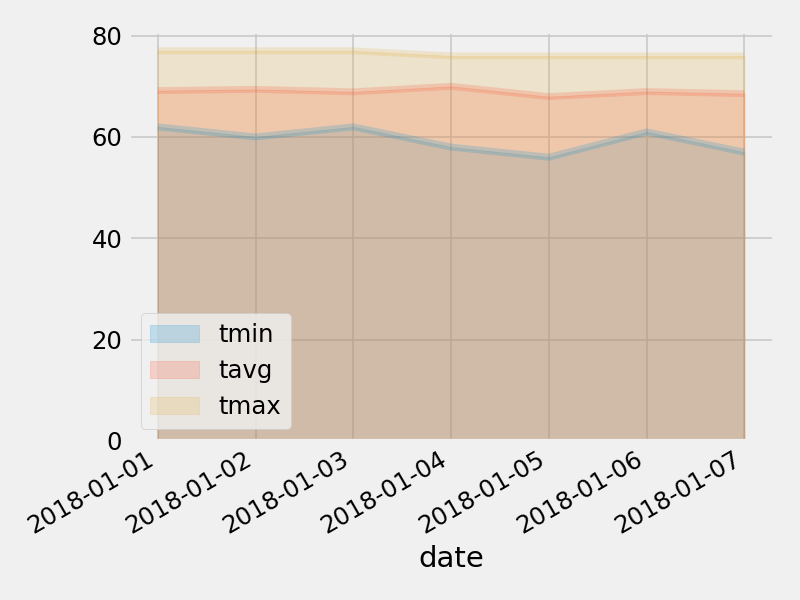

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
